# Sheet 4

In [138]:
import numpy as np
from matplotlib import pyplot as plt

## 3 QDA
### (a)

In [139]:
pts = np.load("data/data1d.npy")
labels = np.load("data/labels1d.npy")

In [140]:
neg_pts = pts[labels == 0]
neg_mu = neg_pts.mean()
neg_sigma = neg_pts.std()

pos_pts = pts[labels == 1]
pos_mu = pos_pts.mean()
pos_sigma = pos_pts.std()

### (b)

(array([ 5.,  7., 12., 26., 29., 49., 23., 26., 16.,  7.]),
 array([-1.52228054, -0.85109593, -0.17991132,  0.49127328,  1.16245789,
         1.83364249,  2.5048271 ,  3.1760117 ,  3.84719631,  4.51838091,
         5.18956552]),
 <BarContainer object of 10 artists>)

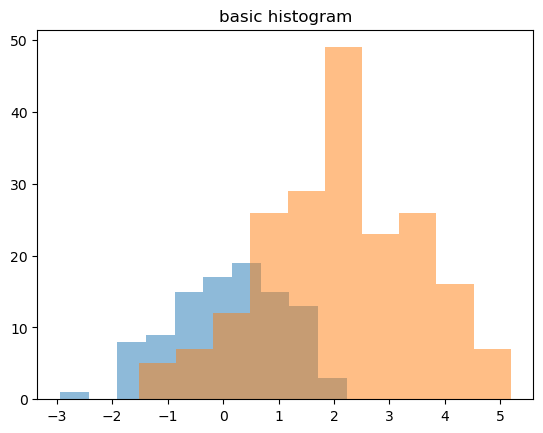

In [141]:
plt.title("basic histogram")
plt.hist(neg_pts, alpha=0.5, bins=10, label="negative")
plt.hist(pos_pts, alpha=0.5, bins=10, label="positive")

In [142]:
from scipy.stats import norm


def qda_plot(neg_prior: float):
    pos_prior = 1 - neg_prior

    x_min = -10
    x_max = 10

    x = np.linspace(x_min, x_max, 1000)
    neg_gauss: np.ndarray = norm(loc=neg_mu, scale=neg_sigma).pdf(x)  # pyright: ignore
    pos_gauss: np.ndarray = norm(loc=pos_mu, scale=pos_sigma).pdf(x)  # pyright: ignore
    prob_norm = neg_gauss + pos_gauss

    neg_post = neg_gauss * neg_prior / prob_norm
    pos_post = pos_gauss * pos_prior / prob_norm

    plt.plot(x, neg_gauss, label="negative gaussian")
    plt.plot(x, pos_gauss, label="positive gaussian")
    plt.plot(x, neg_post, label="negative posteriori")
    plt.plot(x, pos_post, label="positive posteriori")
    plt.title("gaussians and corresponding posterior distributions")
    plt.grid()
    plt.legend()
    plt.show()

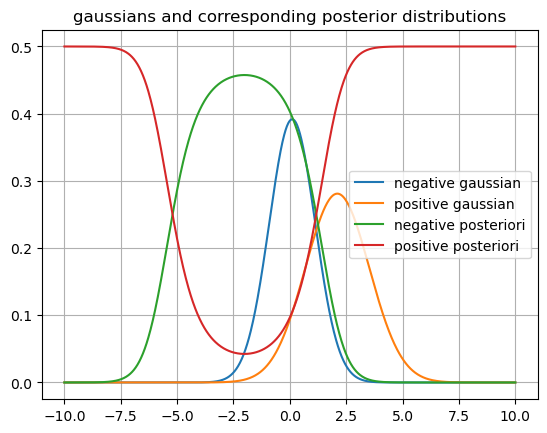

In [143]:
qda_plot(0.5)

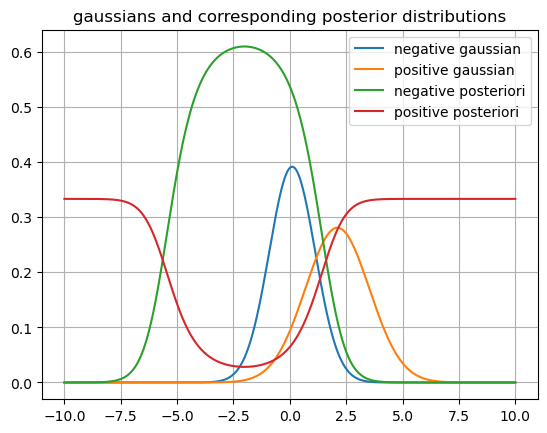

In [144]:
qda_plot(2.0 / 3)

Changing the prior rescales the posteriors, keeping the shape, and changes the decision boundary, 

## 4 Trees and Random Forests

### (b)

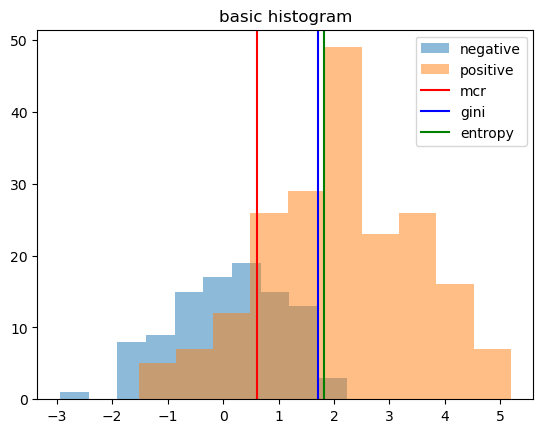

In [145]:
# load the data
pts = np.load("data/data1d.npy")
labels = np.load("data/labels1d.npy")

# TODO: Sort the points to easily split them
sorted_indices = np.argsort(pts)
pts = pts[sorted_indices]
labels = labels[sorted_indices].astype(int)


# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate
from math import log2


def gini(p):
    return 2 * p * (1 - p)


def entropy(p, eps=0.001):
    if abs(p - 1) < eps or abs(p) < eps:
        return 0
    try:
        return -p * log2(p) - (1 - p) * log2(1 - p)
    except ValueError:
        print(p)


def mcr(p):
    return min(p, 1 - p)


def probabilities(partition):
    # divide counts by size of dataset to get cluster probabilites
    return np.unique(partition, return_counts=True)[1] / len(partition)


def compute_split_measure(l, l0, l1, method):
    p0 = probabilities(l0)
    p1 = probabilities(l1)
    p = probabilities(l)
    return method(p) - (len(l0) * method(p0) + len(l1) * method(p1)) / (len(l))


# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
# TODO: Then, Compute the split that each criterion favours and visualize them
#       (e.g. with a histogram for each class and vertical lines to show the splits)


def delta(l, threshold_idx, method):
    # I think the "probabilities" function won't work (output dimensions depend on the partition)
    left = l[:threshold_idx]
    right = l[threshold_idx:]
    return method(l.mean()) - (
        method(left.mean()) * len(left) + method(right.mean()) * len(right)
    ) / len(l)


def optimize(l, method):
    best_idx = 1
    best_val = 0
    for idx in range(1, len(l)):
        val = delta(l, idx, method)
        if val > best_val:
            best_val = val
            best_idx = idx
    return best_idx


def get_split(x, l, method):
    idx = optimize(l, method)
    return (x[idx - 1] + x[idx]) / 2


neg_pts = pts[labels == 0]
pos_pts = pts[labels == 1]
plt.title("basic histogram")
plt.hist(neg_pts, alpha=0.5, bins=10, label="negative")
plt.hist(pos_pts, alpha=0.5, bins=10, label="positive")
plt.axvline(get_split(pts, labels, mcr), label="mcr", color="red")
plt.axvline(get_split(pts, labels, gini), label="gini", color="blue")
plt.axvline(get_split(pts, labels, entropy), label="entropy", color="green")
plt.legend()
plt.show()

### (b)

In [146]:
# load the dijet data
features = np.load("data/dijet_features_normalized.npy")
labels = np.load("data/dijet_labels.npy")

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)

from sklearn.model_selection import PredefinedSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features.T, labels, test_size=200, shuffle=True, random_state=42
)
# sadly, GridSearchCV can't take an explicit split as a parameter
# i-th element will be in fold[i]-th fold
# negative value => element is always in the training set
# thus we have one fold with 200 elements
val_fold = [-1] * (len(X_train) - 200) + [0] * 200
val_split = PredefinedSplit(val_fold)

In [147]:
from sklearn.ensemble import RandomForestClassifier

# TODO: train a random forest classifier for each combination of specified hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [5, 10, 20, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 5, 10, None],
}

# Perform grid search
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=val_split, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [5, 10, 20, 100]},
             scoring='accuracy')

In [148]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set
from sklearn.metrics import accuracy_score

print("final hyperparameters:", grid_search.best_params_)
print("accuracy on the test set:", accuracy_score(y_test, grid_search.predict(X_test)))

final hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
accuracy on the test set: 0.795
